In [1]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)
ap = sqlContext.read.format("org.apache.spark.sql.cassandra").load(table="pollution", keyspace="dice")
ap1 = ap

In [59]:
ap = ap1

In [3]:
ap.printSchema()
ap.first()

root
 |-- location: string (nullable = true)
 |-- scraped: timestamp (nullable = true)
 |-- benzene: float (nullable = true)
 |-- co: float (nullable = true)
 |-- hour: string (nullable = true)
 |-- humidity: float (nullable = true)
 |-- no: float (nullable = true)
 |-- no2: float (nullable = true)
 |-- nox: float (nullable = true)
 |-- paraxylene: float (nullable = true)
 |-- pm: float (nullable = true)
 |-- pressure: float (nullable = true)
 |-- so2: float (nullable = true)
 |-- solar_radiation: float (nullable = true)
 |-- temperature: float (nullable = true)
 |-- tolulene: float (nullable = true)
 |-- wind_direction: string (nullable = true)
 |-- windspeed: float (nullable = true)



Row(location=u'bezigrad', scraped=datetime.datetime(2017, 4, 14, 9, 0), benzene=None, co=None, hour=u'09:00', humidity=60.599998474121094, no=13.850000381469727, no2=None, nox=59.650001525878906, paraxylene=None, pm=17.974000930786133, pressure=980.4000244140625, so2=0.0, solar_radiation=421.0, temperature=12.699999809265137, tolulene=None, wind_direction=None, windspeed=None)

In [8]:
ap.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
benzene,178,2.1235955056179776,0.33004792389906346,2.0,3.0
co,201,0.1523631838479297,0.08821288081430281,0.0,0.475
humidity,202,61.63168296247426,18.156645150608643,28.3,97.5
no,401,15.070448880044376,25.58227132185717,0.0,174.0
no2,400,36.662625041008,19.862348612916957,0.0,108.0
nox,202,36.10470303922597,35.52191177247886,0.0,210.8
paraxylene,178,3.466292134831461,1.1700059220695862,2.0,8.0
pm,401,20.07438654257472,9.813991910917617,0.0,64.0
pressure,202,983.5554440942141,4.08133442842392,974.0,991.3


In [60]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

hourTokens = udf(lambda time: float(time.weekday() * 24 + time.hour), DoubleType())
ap = ap.withColumn('hour', hourTokens(ap.scraped))
minuteTokens = udf(lambda time: float(time.hour * 60 + time.minute), DoubleType())
ap = ap.withColumn('minute', minuteTokens(ap.scraped))
weekTokens = udf(lambda time: float(time.weekday()), DoubleType())
ap = ap.withColumn('weekday', weekTokens(ap.scraped))

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="location", outputCol="location_id").fit(ap)
ap = indexer.transform(ap)

In [61]:
ap = ap.select('hour', 'minute', 'weekday', 'location_id', 'pm')

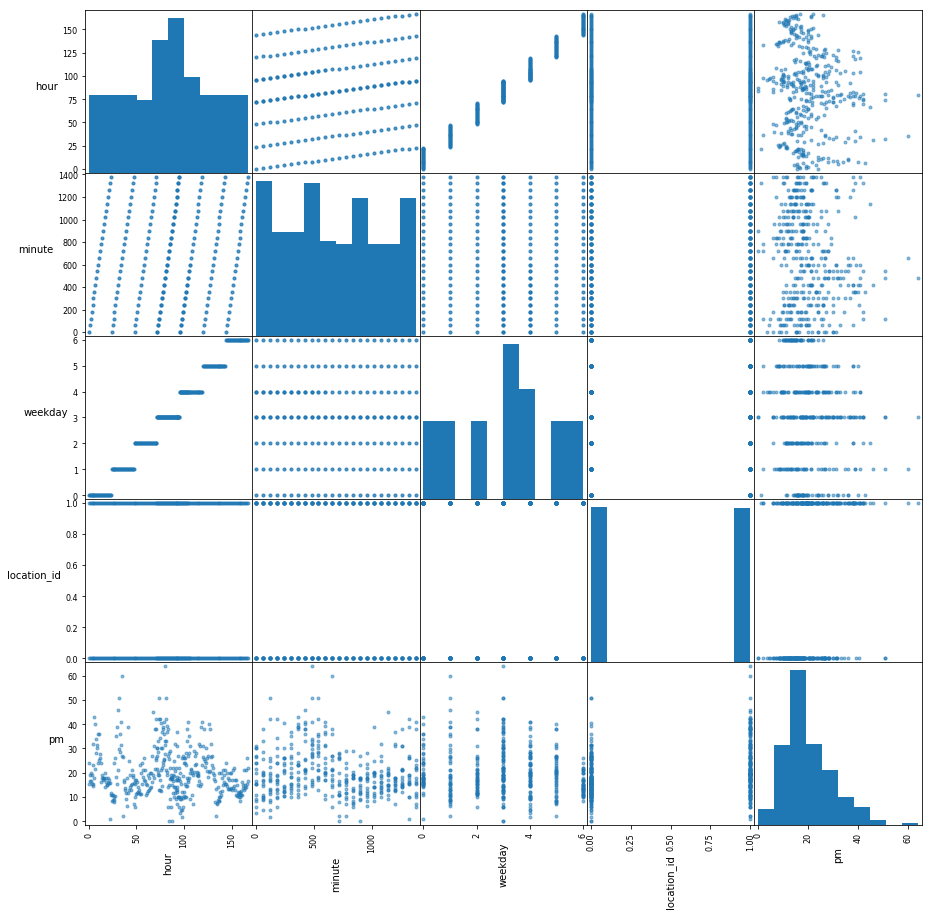

In [50]:
%matplotlib inline
import pandas as pd

sampled_data = ap.toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(15, 15));

n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)

In [62]:
from pyspark.ml.feature import VectorAssembler
not_use = ['pm']
assembler = VectorAssembler(inputCols=[x for x in ap.columns if x not in not_use], outputCol='features')
ap = assembler.transform(ap)

In [63]:
from pyspark.ml.feature import RFormula

formula = RFormula(formula="pm ~ hour + minute + location_id + hour:location_id + minute:location_id", featuresCol="featuresR",)
ap = formula.fit(ap).transform(ap)

In [64]:
train, test = ap.randomSplit([0.7, 0.3], 1234)
train.first()

Row(hour=0.0, minute=0.0, weekday=0.0, location_id=0.0, pm=15.347000122070312, features=SparseVector(4, {}), featuresR=SparseVector(7, {}), label=15.347000122070312)

In [67]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import itertools
from tqdm import tqdm_notebook

best = []

comb = list(itertools.product([30], range(40,60,2), range(1,30,2)))

for c in tqdm_notebook(comb):
    dt = DecisionTreeRegressor(maxDepth=c[0], maxBins=c[1], minInstancesPerNode=c[2], labelCol='pm')
    model = dt.fit(train)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(labelCol="pm", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    best.append((rmse, c))

In [68]:
sorted(best)[:10]

[(8.043376111831762, (30, 40, 3)),
 (8.267357055371134, (30, 52, 5)),
 (8.305455969077896, (30, 42, 3)),
 (8.33261773873491, (30, 48, 3)),
 (8.451823133631247, (30, 54, 3)),
 (8.465608256012885, (30, 52, 7)),
 (8.479496662397628, (30, 52, 3)),
 (8.53092721036305, (30, 46, 5)),
 (8.682367152285812, (30, 42, 7)),
 (8.684226144094865, (30, 52, 9))]